In [1]:
# MRC (Mobility Report Cards) — standalone from analysis_gender_v2
# Run from repo root (Econometrics) or from submission/; data path is set accordingly
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import statsmodels.formula.api as smf

# Data path: repo root = "data/dataverse_files", from submission/ = "../data/dataverse_files"
_data = "data/dataverse_files"
if not os.path.isdir(_data):
    _data = os.path.join("..", "data", "dataverse_files")

mrc4 = pd.read_csv(os.path.join(_data, "mrc_table4.csv"))
mrc10 = pd.read_csv(os.path.join(_data, "mrc_table10.csv"))

print(f"MRC4: {mrc4.shape[0]:,} colleges (gender-stratified)")
print(f"MRC10: {mrc10.shape[0]:,} colleges (characteristics)")

os.makedirs("figures", exist_ok=True)

MRC4: 2,466 colleges (gender-stratified)
MRC10: 2,463 colleges (characteristics)


GENDER GAP IN EARNINGS RANK (F - M) BY COLLEGE TIER
                                               mean_gap  median_gap  \
tier_name                                                             
Less than two-year schools of any type           -0.142      -0.138   
Nonselective four-year private not-for-profit    -0.130      -0.098   
Two-year (public and private not-for-profit)     -0.119      -0.115   
Nonselective four-year public                    -0.119      -0.101   
Selective private                                -0.111      -0.102   
Selective public                                 -0.100      -0.103   
Highly selective public                          -0.096      -0.095   
Highly selective private                         -0.088      -0.089   
Two-year for-profit                              -0.088      -0.078   
Four-year for-profit                             -0.084      -0.086   
Other elite schools (public and private)         -0.080      -0.078   
Ivy Plus                 

/var/folders/5n/m0cb4ndx66v3t7_fsbn3q1n40000gn/T/ipykernel_6667/3473309511.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mrc4['k_rank_gap'] = mrc4['k_rank_f'] - mrc4['k_rank_m']
/var/folders/5n/m0cb4ndx66v3t7_fsbn3q1n40000gn/T/ipykernel_6667/3473309511.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mrc4['k_median_gap'] = mrc4['k_median_f'] - mrc4['k_median_m']


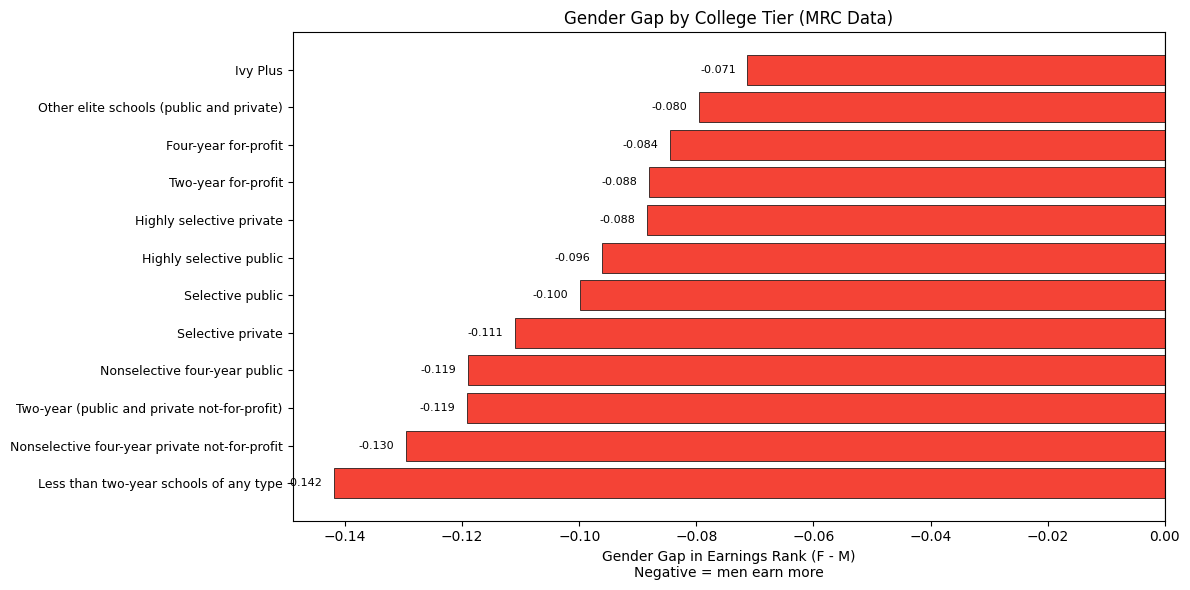

In [2]:
# Gender gap in earnings rank by college tier (MRC Table 4)
mrc4['k_rank_gap'] = mrc4['k_rank_f'] - mrc4['k_rank_m']
mrc4['k_median_gap'] = mrc4['k_median_f'] - mrc4['k_median_m']

# Drop rows with missing gender data
mrc4_clean = mrc4.dropna(subset=['k_rank_f', 'k_rank_m', 'tier_name']).copy()

# Exclude oddball tiers
exclude_tiers = ['Not in college between the ages of 19-22', 'Attending college with insufficient data']
mrc4_clean = mrc4_clean[~mrc4_clean['tier_name'].isin(exclude_tiers)]

print('='*70)
print('GENDER GAP IN EARNINGS RANK (F - M) BY COLLEGE TIER')
print('='*70)
tier_gap = mrc4_clean.groupby('tier_name').agg(
    mean_gap=('k_rank_gap', 'mean'),
    median_gap=('k_rank_gap', 'median'),
    n_colleges=('k_rank_gap', 'count'),
    male_rank=('k_rank_m', 'mean'),
    female_rank=('k_rank_f', 'mean')
).sort_values('mean_gap')
print(tier_gap.round(3))

# Visualise
fig, ax = plt.subplots(figsize=(12, 6))
tier_gap_sorted = tier_gap.sort_values('mean_gap')
colors = ['#F44336' if g < 0 else '#4CAF50' for g in tier_gap_sorted['mean_gap']]
ax.barh(range(len(tier_gap_sorted)), tier_gap_sorted['mean_gap'], color=colors, edgecolor='black', linewidth=0.5)
ax.set_yticks(range(len(tier_gap_sorted)))
ax.set_yticklabels(tier_gap_sorted.index, fontsize=9)
ax.axvline(0, color='black', linewidth=0.8)
ax.set_xlabel('Gender Gap in Earnings Rank (F - M)\nNegative = men earn more')
ax.set_title('Gender Gap by College Tier (MRC Data)')
for i, (_, row) in enumerate(tier_gap_sorted.iterrows()):
    ax.text(row['mean_gap'] - 0.002, i, f'{row["mean_gap"]:.3f}', va='center', ha='right' if row['mean_gap'] < 0 else 'left',
            fontsize=8)
plt.tight_layout()
fig.savefig('figures/mrc_gender_gap_by_tier.png', bbox_inches='tight', dpi=150)
plt.show()

In [3]:
# Merge MRC4 (gender gap) with MRC10 (college characteristics)
merged = mrc4_clean.merge(mrc10[['super_opeid', 'exp_instr_pc_2000', 'grad_rate_150_p_2002',
                                   'sticker_price_2000', 'avgfacsal_2001', 'sat_avg_2001',
                                   'public', 'hbcu']],
                           on='super_opeid', how='inner')

print(f'Merged dataset: {len(merged)} colleges')
print(f'Gender gap (k_rank): mean={merged["k_rank_gap"].mean():.3f}, std={merged["k_rank_gap"].std():.3f}')

# Correlations: institutional features vs gender gap
print('\n--- Correlations with gender gap (k_rank_gap) ---')
corr_vars = ['exp_instr_pc_2000', 'grad_rate_150_p_2002', 'sticker_price_2000',
             'avgfacsal_2001', 'sat_avg_2001']
for v in corr_vars:
    sub = merged.dropna(subset=[v, 'k_rank_gap'])
    r, p = stats.pearsonr(sub[v], sub['k_rank_gap'])
    sig = '***' if p < 0.01 else '**' if p < 0.05 else '*' if p < 0.1 else ''
    print(f'  {v:30s}: r={r:+.3f} (p={p:.4f}) {sig}')

# Regression: gender gap ~ institutional features
print('\n--- OLS: k_rank_gap ~ institutional characteristics ---')
reg_merged = merged.dropna(subset=['k_rank_gap', 'exp_instr_pc_2000', 'grad_rate_150_p_2002', 'sticker_price_2000']).copy()
# Log spending (right-skewed)
reg_merged['log_exp_instr'] = np.log(reg_merged['exp_instr_pc_2000'].clip(lower=1))
reg_merged['log_sticker'] = np.log(reg_merged['sticker_price_2000'].clip(lower=1))

m = smf.ols('k_rank_gap ~ log_exp_instr + grad_rate_150_p_2002 + log_sticker + public',
            data=reg_merged).fit(cov_type='HC1')
print(m.summary2().tables[1].to_string())

Merged dataset: 1921 colleges
Gender gap (k_rank): mean=-0.110, std=0.054

--- Correlations with gender gap (k_rank_gap) ---
  exp_instr_pc_2000             : r=+0.155 (p=0.0000) ***
  grad_rate_150_p_2002          : r=+0.040 (p=0.0951) *
  sticker_price_2000            : r=+0.172 (p=0.0000) ***
  avgfacsal_2001                : r=+0.253 (p=0.0000) ***
  sat_avg_2001                  : r=-0.072 (p=0.0487) **

--- OLS: k_rank_gap ~ institutional characteristics ---
                         Coef.  Std.Err.          z         P>|z|    [0.025    0.975]
Intercept            -0.336243  0.030960 -10.860646  1.774895e-27 -0.396923 -0.275563
log_exp_instr         0.018810  0.003972   4.735978  2.180007e-06  0.011026  0.026595
grad_rate_150_p_2002 -0.037591  0.010005  -3.757002  1.719609e-04 -0.057201 -0.017980
log_sticker           0.009465  0.002939   3.220695  1.278802e-03  0.003705  0.015224
public                0.014695  0.005972   2.460674  1.386763e-02  0.002990  0.026399


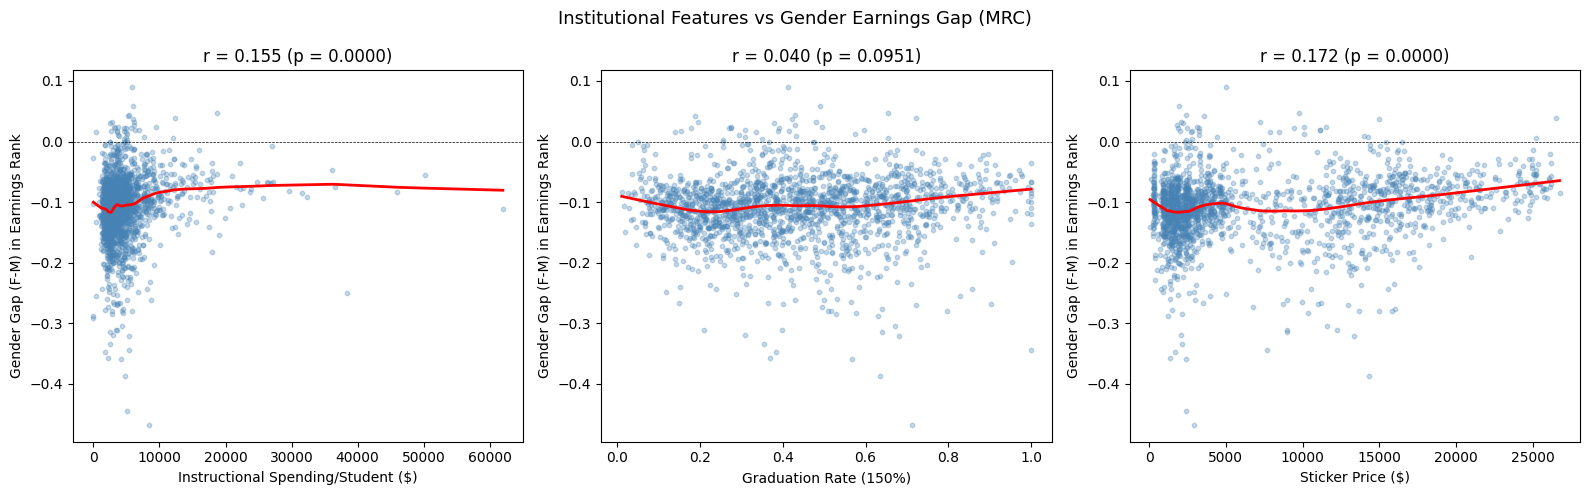

In [4]:
# Scatter plots: key institutional features vs gender gap
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

for ax, (xvar, xlabel) in zip(axes, [
    ('exp_instr_pc_2000', 'Instructional Spending/Student ($)'),
    ('grad_rate_150_p_2002', 'Graduation Rate (150%)'),
    ('sticker_price_2000', 'Sticker Price ($)')
]):
    sub = merged.dropna(subset=[xvar, 'k_rank_gap'])
    ax.scatter(sub[xvar], sub['k_rank_gap'], alpha=0.3, s=10, color='steelblue')
    # LOWESS fit
    from statsmodels.nonparametric.smoothers_lowess import lowess
    lo = lowess(sub['k_rank_gap'].values, sub[xvar].values, frac=0.3)
    ax.plot(lo[:, 0], lo[:, 1], color='red', linewidth=2)
    ax.axhline(0, color='black', linewidth=0.5, linestyle='--')
    ax.set_xlabel(xlabel)
    ax.set_ylabel('Gender Gap (F-M) in Earnings Rank')
    r, p = stats.pearsonr(sub[xvar], sub['k_rank_gap'])
    ax.set_title(f'r = {r:.3f} (p = {p:.4f})')

fig.suptitle('Institutional Features vs Gender Earnings Gap (MRC)', fontsize=13)
plt.tight_layout()
fig.savefig('figures/mrc_institutional_features_vs_gap.png', bbox_inches='tight', dpi=150)
plt.show()

GENDER EARNINGS GAP BY SAT SELECTIVITY QUARTILE
               mean_gap    n  mean_sat
sat_quartile                          
Q1 (Low SAT)     -0.082  196   937.418
Q2               -0.102  176  1031.804
Q3               -0.110  184  1114.197
Q4 (High SAT)    -0.096  186  1261.033

--- By Barron's selectivity index ---
          mean  count
barrons              
999     -0.118    867
3       -0.117    225
4       -0.105    481
5       -0.095    160
2       -0.091     92
9       -0.085     24
1       -0.078     72


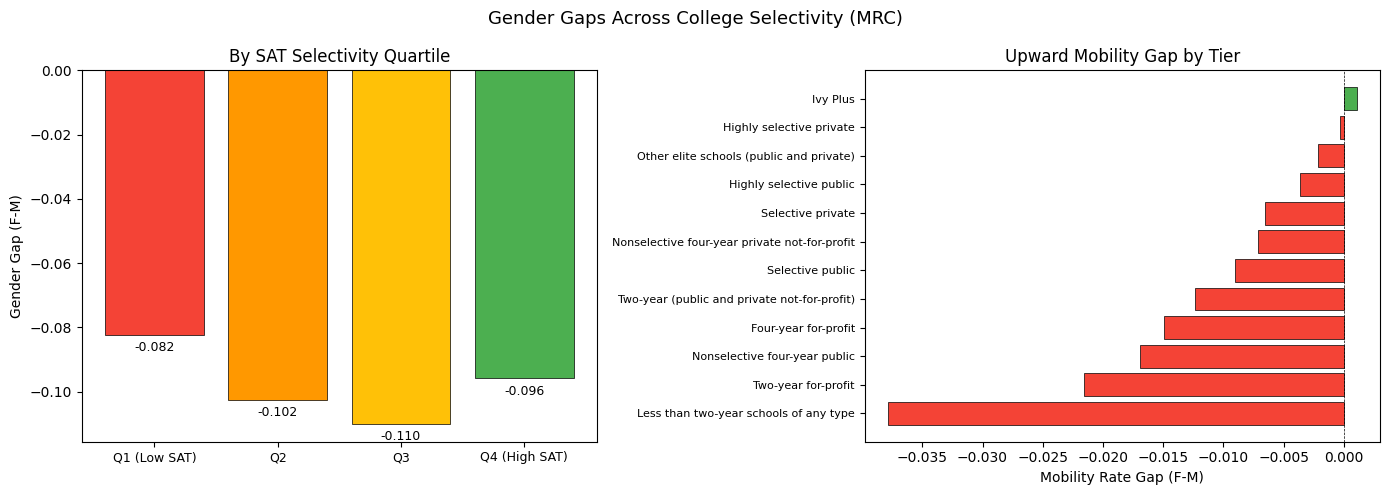

In [5]:
# Gender gap by selectivity (SAT average as proxy)
sub = merged.dropna(subset=['sat_avg_2001', 'k_rank_gap']).copy()
sub['sat_quartile'] = pd.qcut(sub['sat_avg_2001'], 4, labels=['Q1 (Low SAT)', 'Q2', 'Q3', 'Q4 (High SAT)'])

print('='*70)
print('GENDER EARNINGS GAP BY SAT SELECTIVITY QUARTILE')
print('='*70)
sel = sub.groupby('sat_quartile').agg(
    mean_gap=('k_rank_gap', 'mean'),
    n=('k_rank_gap', 'count'),
    mean_sat=('sat_avg_2001', 'mean')
)
print(sel.round(3))

# Also by Barron's selectivity
sub2 = merged.dropna(subset=['k_rank_gap']).copy()
sub2 = sub2.merge(mrc10[['super_opeid', 'barrons']], on='super_opeid', how='left')
sub2 = sub2.dropna(subset=['barrons'])
barrons = sub2.groupby('barrons')['k_rank_gap'].agg(['mean', 'count']).sort_values('mean')
print('\n--- By Barron\'s selectivity index ---')
print(barrons.round(3))

# Visualise
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# SAT quartiles
ax = axes[0]
x = range(4)
ax.bar(x, sel['mean_gap'], color=['#F44336', '#FF9800', '#FFC107', '#4CAF50'], edgecolor='black', linewidth=0.5)
ax.set_xticks(x)
ax.set_xticklabels(sel.index, fontsize=9)
ax.axhline(0, color='black', linewidth=0.5, linestyle='--')
ax.set_ylabel('Gender Gap (F-M)')
ax.set_title('By SAT Selectivity Quartile')
for i, v in enumerate(sel['mean_gap']):
    ax.text(i, v - 0.005, f'{v:.3f}', ha='center', fontsize=9)

# Mobility rate gap by tier
ax = axes[1]
mrc4_clean['mr_gap'] = mrc4_clean['mr_kq5_pq1_f'] - mrc4_clean['mr_kq5_pq1_m']
mr_tier = mrc4_clean.groupby('tier_name')['mr_gap'].mean().sort_values()
mr_tier = mr_tier[~mr_tier.index.isin(exclude_tiers)]
colors = ['#F44336' if g < 0 else '#4CAF50' for g in mr_tier]
ax.barh(range(len(mr_tier)), mr_tier, color=colors, edgecolor='black', linewidth=0.5)
ax.set_yticks(range(len(mr_tier)))
ax.set_yticklabels(mr_tier.index, fontsize=8)
ax.axvline(0, color='black', linewidth=0.5, linestyle='--')
ax.set_xlabel('Mobility Rate Gap (F-M)')
ax.set_title('Upward Mobility Gap by Tier')

fig.suptitle('Gender Gaps Across College Selectivity (MRC)', fontsize=13)
plt.tight_layout()
fig.savefig('figures/mrc_gender_gaps_selectivity.png', bbox_inches='tight', dpi=150)
plt.show()